In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
!pip install -q transformers easyocr accelerate timm torch torchvision opencv-python matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from PIL import Image
import torch, matplotlib.pyplot as plt, cv2

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)

print("✅ OWL-ViT model loaded on", device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

✅ OWL-ViT model loaded on cuda


In [ ]:
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)


Saving washing_machine.jpg to washing_machine.jpg
Uploaded: washing_machine.jpg


In [ ]:
THRESHOLD = 0.05  # lower from 0.25 → 0.05

detected_boxes = []
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    if score > THRESHOLD:
        x0, y0, x1, y1 = map(int, box.tolist())
        detected_boxes.append((x0, y0, x1, y1))
        cv2.rectangle(image_cv, (x0, y0), (x1, y1), (0,255,0), 2)
        cv2.putText(image_cv, texts[0][label], (x0, y0-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)


In [ ]:
texts = [[
    "green circular power button",
    "rectangular start button",
    "washing machine control panel buttons",
    "washing machine display screen"
]]


In [ ]:
image_resized = image.resize((512, 512))
inputs = processor(text=texts, images=image_resized, return_tensors="pt").to("cuda")
outputs = model(**inputs)
target_sizes = torch.Tensor([image_resized.size[::-1]]).to("cuda")
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes)[0]


In [ ]:
for score, label in zip(results["scores"], results["labels"]):
    print(f"{texts[0][label]} → {score:.3f}")


In [ ]:
import easyocr, numpy as np
reader = easyocr.Reader(['en'])
ocr_results = reader.readtext(np.array(image))
for (bbox, text, conf) in ocr_results:
    print(f"{text} ({conf:.2f})")


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteWash Cycles_ (0.79)
Power (0.68)
Heavy (1.00)
Duty (1.00)
Whites (1.00)
Normal (1.00)
Perm (0.96)
Delicate (0.99)
Start (0.97)
Eco (1.00)
Press (1.00)
II (0.59)
Cancel (1.00)
Favorites (0.70)
Bulky (1.00)
Quaick (0.44)
Rispie (0.50)
Spin (1.00)
Pause (0.61)
Selections_ (0.99)
Options (1.00)
Status_ (1.00)
Temp (1.00)
Soak (1.00)
Pre- (1.00)
Wash (0.96)
Cold (1.00)
Cool (1.00)
Warm (0.99)
Hot (1.00)
Wash (0.90)
Speed Queen (0.66)
Spin (1.00)
Second (1.00)
Third (1.00)
Speed (0.95)
Rinse (1.00)
Rinse (1.00)
PROFESSIONAL SERIES (0.91)
No Spin (1.00)
Medium (1.00)
High (1.00)
Rinse (1.00)
Soil (0.99)
Delay (0.81)
Signal (0.77)
Level (1.00)
Start (0.97)
Light (0.59)
Medium (1.00)
Heavy (1.00)
Max (1.00)
Control Lock (0.96)
Door Lock (1.00)
Spin (1.00)
Washer (Bottom) (1.00)
Low (1.00)


In [ ]:
# Create mapping dictionary from OCR text to machine operation
washing_machine_actions = {
    "Power": "Press the Power button to turn on the washing machine. The display will light up when ready.",
    "Cancel": "If you need to stop a cycle, press the Cancel button to power off the machine.",
    "Start": "Press the Start button to begin the wash cycle. The door will lock once the cycle starts.",
    "Pause": "You can press the Pause button to temporarily stop the wash cycle if needed.",
    "Heavy": "Select Heavy Duty for large, heavily soiled loads like jeans or towels.",
    "Normal": "Select Normal Eco for regular washing. It balances performance and energy use.",
    "Delicate": "Use the Delicate cycle for sensitive fabrics or lightweight garments.",
    "Quick": "Select Quick Wash for small or lightly soiled loads that need a fast clean.",
    "Whites": "Choose Whites for white clothing using hot water for deep cleaning.",
    "Perm": "Use Permanent Press to reduce wrinkles on synthetic fabrics.",
    "Rinse": "The Rinse and Spin cycle removes detergent residue and extracts excess water.",
    "Spin": "Select Spin only to remove excess water from clothes.",
    "Temp": "Use the Temp buttons to choose water temperature — Cold, Warm, or Hot.",
    "Cold": "Cold wash is best for dark or colored clothes and energy saving.",
    "Warm": "Warm wash is suitable for general clothes cleaning.",
    "Hot": "Hot wash removes stubborn stains and sanitizes whites.",
    "Soil": "Set the Soil Level according to how dirty your laundry is.",
    "Light": "Light soil means shorter washing time for lightly used clothes.",
    "Medium": "Medium soil is ideal for normal daily wear.",
    "Heavy Soil": "Heavy soil increases agitation and wash time for dirtier loads.",
    "Max": "Max soil level gives the longest and most powerful wash cycle.",
    "Delay": "Use Delay Start to begin the washing cycle later automatically.",
    "Signal": "Use Signal to adjust or mute the alert tone at the end of the cycle.",
    "Soak": "The Soak option allows clothes to soak before the main wash for tough stains.",
    "Pre-Wash": "Pre-Wash adds an initial cleaning step before the main wash.",
    "Second": "Second Rinse ensures extra detergent removal.",
    "Third": "Third Rinse gives maximum rinse cycles for allergy-sensitive loads.",
    "Control Lock": "Control Lock prevents accidental button presses during operation.",
    "Door Lock": "Door Lock light turns on when the door is securely locked during a cycle.",
}


In [ ]:
instruction_list = []

for (bbox, text, conf) in ocr_results:
    for key in washing_machine_actions:
        if key.lower() in text.lower():
            instruction_list.append({
                "label": key,
                "text": text,
                "confidence": round(conf, 2),
                "instruction": washing_machine_actions[key]
            })

# Print a few matches
import json
print(json.dumps(instruction_list[:10], indent=2))
print(f"\nTotal instructions matched: {len(instruction_list)}")


[
  {
    "label": "Power",
    "text": "Power",
    "confidence": 0.68,
    "instruction": "Press the Power button to turn on the washing machine. The display will light up when ready."
  },
  {
    "label": "Heavy",
    "text": "Heavy",
    "confidence": 1.0,
    "instruction": "Select Heavy Duty for large, heavily soiled loads like jeans or towels."
  },
  {
    "label": "Whites",
    "text": "Whites",
    "confidence": 1.0,
    "instruction": "Choose Whites for white clothing using hot water for deep cleaning."
  },
  {
    "label": "Normal",
    "text": "Normal",
    "confidence": 1.0,
    "instruction": "Select Normal Eco for regular washing. It balances performance and energy use."
  },
  {
    "label": "Perm",
    "text": "Perm",
    "confidence": 0.96,
    "instruction": "Use Permanent Press to reduce wrinkles on synthetic fabrics."
  },
  {
    "label": "Delicate",
    "text": "Delicate",
    "confidence": 0.99,
    "instruction": "Use the Delicate cycle for sensitive fabrics

In [ ]:
ordered_labels = [
    "Power", "Heavy", "Normal", "Delicate", "Quick", "Temp",
    "Soil", "Delay", "Signal", "Start", "Door Lock"
]

final_guide = []
for label in ordered_labels:
    for item in instruction_list:
        if item["label"] == label:
            final_guide.append(item["instruction"])

complete_instruction = " ".join(final_guide)
print(complete_instruction)


Press the Power button to turn on the washing machine. The display will light up when ready. Select Heavy Duty for large, heavily soiled loads like jeans or towels. Select Heavy Duty for large, heavily soiled loads like jeans or towels. Select Normal Eco for regular washing. It balances performance and energy use. Use the Delicate cycle for sensitive fabrics or lightweight garments. Use the Temp buttons to choose water temperature — Cold, Warm, or Hot. Set the Soil Level according to how dirty your laundry is. Use Delay Start to begin the washing cycle later automatically. Use Signal to adjust or mute the alert tone at the end of the cycle. Press the Start button to begin the wash cycle. The door will lock once the cycle starts. Press the Start button to begin the wash cycle. The door will lock once the cycle starts. Door Lock light turns on when the door is securely locked during a cycle.


In [ ]:
!pip install -q gTTS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 10.6 MB/s eta 0:00:00


In [ ]:
from gtts import gTTS
tts = gTTS(complete_instruction)
tts.save("washing_machine_full_procedure.mp3")

from google.colab import files
files.download("washing_machine_full_procedure.mp3")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install -q easyocr opencv-python-headless gTTS matplotlib


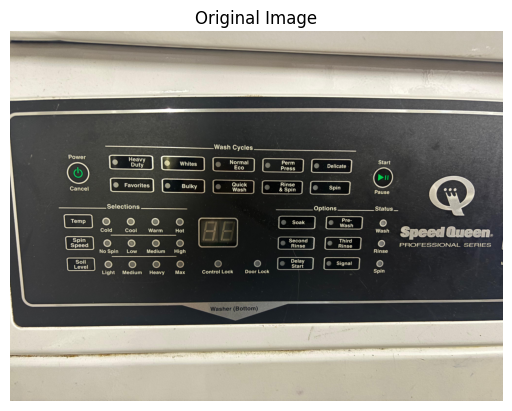

In [ ]:
import cv2, numpy as np, json, matplotlib.pyplot as plt
from PIL import Image
import easyocr

# Load image
image_path = "washing_machine.jpg"
image = cv2.imread(image_path)

if image is None:
    raise ValueError("⚠️ Please upload washing_machine.jpg before running this cell.")

# Convert to RGB for processing and display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Original Image")
plt.show()


Detected button-like regions: 35


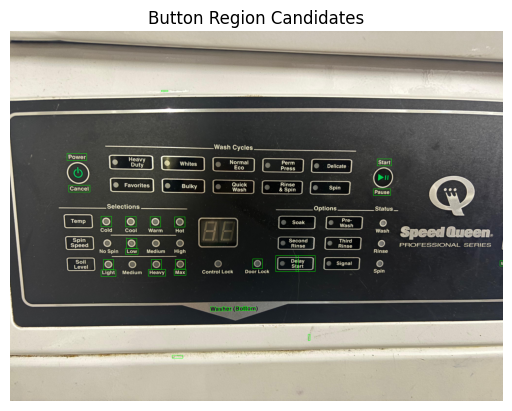

In [ ]:
# Convert to grayscale and apply blur
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Adaptive threshold for button-like regions
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, 25, 10)

# Find contours (possible buttons)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

detected_regions = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / float(h)
    area = cv2.contourArea(cnt)
    # Heuristic: filter out tiny or extremely large areas
    if 200 < area < 8000 and 0.3 < aspect_ratio < 5:
        detected_regions.append((x, y, x+w, y+h))
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

print("Detected button-like regions:", len(detected_regions))

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Button Region Candidates")
plt.show()


In [ ]:
reader = easyocr.Reader(['en'])
ocr_detections = []

for (x0, y0, x1, y1) in detected_regions:
    crop = image_rgb[y0:y1, x0:x1]
    text_results = reader.readtext(crop)
    if text_results:
        texts = [t[1] for t in text_results if t[2] > 0.5]
        if texts:
            ocr_detections.append({
                "bbox": [x0, y0, x1, y1],
                "text": texts,
                "confidence": float(np.mean([t[2] for t in text_results])),
            })

print("OCR detections found:", len(ocr_detections))
print(json.dumps(ocr_detections[:5], indent=2))


OCR detections found: 14
[
  {
    "bbox": [
      1712,
      2262,
      1733,
      2288
    ],
    "text": [
      "5"
    ],
    "confidence": 0.6750950561936975
  },
  {
    "bbox": [
      1639,
      2254,
      1682,
      2289
    ],
    "text": [
      "W"
    ],
    "confidence": 0.9991729778019796
  },
  {
    "bbox": [
      1739,
      2253,
      1763,
      2288
    ],
    "text": [
      "h"
    ],
    "confidence": 0.9991272208916122
  },
  {
    "bbox": [
      744,
      1952,
      866,
      2006
    ],
    "text": [
      "Light"
    ],
    "confidence": 0.7627788549117539
  },
  {
    "bbox": [
      1131,
      1948,
      1273,
      2003
    ],
    "text": [
      "Heavy"
    ],
    "confidence": 0.9999894442144547
  }
]


In [ ]:
washing_machine_actions = {
    "Power": "Press the Power button to turn on the washing machine.",
    "Cancel": "Use Cancel to stop the current wash cycle.",
    "Start": "Press Start to begin the washing cycle.",
    "Pause": "Pause temporarily stops the wash cycle.",
    "Heavy": "Select Heavy Duty for bulky or dirty loads.",
    "Normal": "Select Normal Eco for regular laundry.",
    "Delicate": "Use Delicate for sensitive fabrics.",
    "Whites": "Use Whites for white garments.",
    "Quick": "Use Quick Wash for lightly soiled clothes.",
    "Temp": "Choose water temperature using Temp buttons.",
    "Cold": "Cold water saves energy and prevents color bleeding.",
    "Warm": "Warm water is ideal for regular washing.",
    "Hot": "Hot water sanitizes and removes tough stains.",
    "Soil": "Select soil level for how dirty your laundry is.",
    "Light": "Light for gently used clothes.",
    "Medium": "Medium for everyday laundry.",
    "Heavy Soil": "Heavy for extra dirty clothes.",
    "Max": "Max for maximum cleaning power.",
    "Delay": "Delay Start begins the cycle later automatically.",
    "Signal": "Signal adjusts the end-of-cycle sound.",
    "Soak": "Soak helps remove deep stains before washing.",
    "Pre-Wash": "Adds a short pre-wash before the main cycle.",
    "Rinse": "Adds rinse-only cycle.",
    "Spin": "Drains water and spins clothes.",
    "Control Lock": "Prevents accidental button presses.",
    "Door Lock": "Door Lock light indicates locked door during wash.",
}


In [ ]:
# Get image dimensions for normalization (0–1)
h, w, _ = image.shape

merged_detections = []
for det in ocr_detections:
    x0, y0, x1, y1 = det["bbox"]
    texts = det["text"]
    matched_action = None
    for txt in texts:
        for key in washing_machine_actions:
            if key.lower() in txt.lower():
                matched_action = washing_machine_actions[key]
                break
        if matched_action:
            break

    merged_detections.append({
        "text_detected": texts,
        "bbox_pixels": [x0, y0, x1, y1],
        "bbox_normalized": [x0/w, y0/h, x1/w, y1/h],
        "confidence": det["confidence"],
        "instruction": matched_action if matched_action else "No mapped action."
    })

with open("hybrid_detections.json", "w") as f:
    json.dump(merged_detections, f, indent=2)

print(f"✅ Created hybrid_detections.json with {len(merged_detections)} entries")


✅ Created hybrid_detections.json with 14 entries


In [ ]:
from google.colab import files
files.download("hybrid_detections.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os, shutil

project_dir = "/content/drive/MyDrive/WashingMachine_ARVR"
os.makedirs(project_dir, exist_ok=True)

# Save the available JSONs
shutil.copy("/content/hybrid_detections.json", project_dir + "/hybrid_detections.json")

print("✅ hybrid_detections.json saved successfully to:", project_dir)


✅ hybrid_detections.json saved successfully to: /content/drive/MyDrive/WashingMachine_ARVR


In [ ]:
!ls runs/detect


ls: cannot access 'runs/detect': No such file or directory
